# Bonus1: Parallel Algorithms

### Name: Jayant Kumar


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Parallel/Parallel.pdf)

2. Implement federated averaging or decentralized optimization.

3. Plot the convergence curve. (The x-axis can be ```number of epochs``` or ```number of communication```. You must make sure the label is correct.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo. (If it is submitted to Google Drive or Dropbox, you must make the file open-access.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus1/Bonus1.html



# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.1. Load the data

In [ ]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('/content/drive/My Drive/diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [ ]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [ ]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[-0.01432026  0.07871525  0.02974116 -0.01968019  0.0068688   0.00974899
  -0.06295099  0.02563347]]
test std = 
[[0.97289112 0.96978778 1.08254102 0.9634106  0.90621294 0.8814264
  0.96063992 0.99367588]]


## 1.4. Add a dimension of all ones

In [ ]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


## Worker Node

In [ ]:
class Worker:
    def __init__(self, x, y, q, alpha, lam, beta):
        self.x = x #s-by-d local feature matrix
        self.y = y #s-by-1 local label matrix
        self.s = x.shape[0] #number of local samples
        self.d = x.shape[1] #number of features
        self.w = numpy.zeros((self.d, 1)) #d-by-1 model parameter vecotr
        self.q = q #Number of times local gradient to be performed
        self.v = numpy.zeros((self.d, 1)) #d-by1 momentum
        self.alpha = alpha #Local learning rate
        self.initial_w = numpy.zeros((self.d, 1)) #To store the w broadcasted by server for finding direction at the end
        self.lam = lam #regularization parameter
        self.beta = beta #momentum parameter 
    #Set the model parameters to the latest
    def set_param(self, w):
        self.w = w
        self.initial_w = w
    
    #compute the local loss
    def loss(self):
        yx = numpy.multiply(self.y, self.x) #s-by-d matrix
        yxw = numpy.dot(yx, self.w) #s-by-1 matrix
        vec1 = numpy.exp(-yxw) #s-by-1 matrix
        vec2 = numpy.log(1 + vec1) #s-by-1 matrix
        reg = self.lam / 2*numpy.sum(self.w * self.w)
        losses = numpy.sum(vec2)/self.s + reg #loss function
        return losses
    
    #Compute the local gradient 
    def gradient(self):
        yx = numpy.multiply(self.y, self.x) # s-by-d
        yxw = numpy.dot(yx, self.w) # s-by-1
        vec1 = numpy.exp(yxw) # s-by-1
        vec2 = numpy.divide(yx, 1+vec1) # s-by-d
        reg = self.lam / 2*numpy.sum(self.w * self.w)
        g = -numpy.mean(vec2, axis=0).reshape(self.d, 1)+reg # d-by-1
        return g

    
    #Compute q gradient 
    def gradient_descent_local(self):
        for i in range(self.q):
            gradient = self.gradient()
            self.v = self.beta*self.v + gradient
            self.w -= self.alpha * self.v
            losses = self.loss()
            #print("local gradient ", gradient)
            print("local objective function value ", losses)
            #print("local w", self.w)
        return self.w
    
    #Compute Stochastic gradient descent
    def sgd(self, i, x_rand, y_rand):
        import numpy as np
        xi = x_rand[i,:]
        yi = float(y_rand[i,:])
        # calculate the stochastic gradient and local worker loss
        d = xi.shape[0]
        yx = yi * xi
        yxw = float(np.dot(yx, self.w))
        loss = np.log(1 + np.exp(-yxw))
        reg = lam / 2 * np.sum(self.w * self.w)
        obj = loss + reg
        gradient = -yx.T / (1 + np.exp(yxw))
        gradient = gradient + lam * self.w
        return gradient, obj
    
    #Compute q stochastic gradients 
    def stochgradient_descent_local(self):
        import numpy as np
        for i in range(self.q):
            rand_indices = np.random.permutation(self.s)
            x_rand = self.x[rand_indices,:]
            y_rand = self.y[rand_indices,:]
            stcobj = 0
            for i in range(self.s):
                gradient, obj = self.sgd(i, x_rand, y_rand)
                self.w -= self.alpha * gradient
                stcobj+=obj
            self.alpha *= 0.9 # decrease step size
            stcobj /= self.s
            #self.v = self.beta*self.v + gradient
            #self.w -= self.alpha * self.v
            #losses = self.loss()
            #print("local gradient ", gradient)
            print("local objective function value ", stcobj)
            #print("local w", self.w)
        return self.w
    
    #Find direction to be sent back to server
    def find_direction(self):
        pk = self.initial_w - self.gradient_descent_local()
        return pk
    
    #Find direction to be sent back to server stochastic gradient 
    def find_stochdirection(self):
        pk = self.initial_w - self.stochgradient_descent_local()
        return pk
        

## Server Node

In [ ]:
class Server:
    def __init__(self, m, n, d, alpha, lam):
        self.m = m #number of worker nodes
        self.n = n #number of training samples
        self.d = d #number of features
        self.w = numpy.zeros((d, 1)) #d-by-1 model parameter vector
        self.pk = numpy.zeros((d, 1)) #directions recieved from different workers
        self.alpha = alpha #Server Learning rate
        self.lam = lam #Server reg parameter
        #self.g = numpy.zeros((d, 1)) #d-by-1 gradient
        #self.v = numpy.zeros((d, 1)) #d-by1 momentum
        self.loss = 0 #loss function value
        #self.obj = 0 #objective function value
    
    def broadcast(self):
        return self.w
    
    def aggregate(self, pk, losses):
        self.pk = numpy.mean(numpy.array(pk), axis=0)
        self.loss = sum(losses)
        #self.g = numpy.zeros((self.d, 1))
        #self.loss = 0
        #for k in range(self.m):
            #self.pk += pk[k]
            #self.loss += losses[k]
        #self.pk = self.pk/self.m
        
    def update(self):
        self.w = self.w - self.alpha*self.pk
        self.alpha *= 0.9 # decrease step size
            
    #Compute the objective function (sum of loss and regularization)
    def objective(self):
        reg = self.lam/2 * numpy.sum(self.w*self.w)
        self.obj = self.loss/self.m + reg
        return self.obj
    
    

## Initialization for q=1

In [ ]:
import math

#Create a server and m worker nodes
def create_server_workers(m, x, y, q, alpha, lam, beta):
    n, d = x.shape
    s = math.floor(n / m)
    server = Server(m, n, d, alpha, lam)
    workers = []
    
    for i in range(m):
        indices = list(range(i*s, (i+1)*s))
        #print(x.shape)
        worker = Worker(x[indices, :], y[indices, :], q, alpha, lam, beta)
        workers.append(worker)
        
    return server, workers

m = 4 #number of worker nodes
q = 1
lam = 1E-4 #regularization parameter
alpha = 0.01 #learning rate
beta = 0.9 #momentum parameter 
server, workers = create_server_workers(m, x_train, y_train, q, alpha, lam, beta)

In [ ]:
max_epoch = 50 #number of epochs
communication1 = 0 #number of communication
objective_val_1 = []
for t in range(max_epoch):
    print("----------------------------------epoch"+str(t)+"-------------------------------")
    #step 1: broadcast
    w = server.broadcast()
    communication1 = communication1+1
    for i in range(m):
        workers[i].set_param(w)
        
    #step 2: workers' local computations
    pk_1 = []
    losses_1 = []
    for i in range(m):
        print("Worker "+str(i+1))
        g = workers[i].find_direction()
        pk_1.append(g)
        l = workers[i].loss()
        losses_1.append(l)
        
    #step 3: aggregate the workers' outputs
    server.aggregate(pk_1, losses_1)
    communication1= communication1+1
    
    #step 4: server update the model parameters
    server.update() #compute gradient
    obj = server.objective() #compute objective function
    objective_val_1.append(obj)
    print('Objective function value = '+str(obj))

----------------------------------epoch0-------------------------------
Worker 1
local objective function value  0.6918444003678402
Worker 2
local objective function value  0.6899931718501962
Worker 3
local objective function value  0.6895996302991593
Worker 4
local objective function value  0.6880889283800748
Objective function value = 0.6898815430189428
----------------------------------epoch1-------------------------------
Worker 1
local objective function value  0.6856777559317457
Worker 2
local objective function value  0.6814957002694775
Worker 3
local objective function value  0.6820321124314521
Worker 4
local objective function value  0.6788300970049154
Objective function value = 0.6820090016596708
----------------------------------epoch2-------------------------------
Worker 1
local objective function value  0.6755489145712583
Worker 2
local objective function value  0.6687204588936728
Worker 3
local objective function value  0.6713127504850802
Worker 4
local objective functio

## Initialization for q=8

In [ ]:
import math

#Create a server and m worker nodes
def create_server_workers(m, x, y, q, alpha, lam, beta):
    n, d = x.shape
    s = math.floor(n / m)
    server = Server(m, n, d, alpha, lam)
    workers = []
    
    for i in range(m):
        indices = list(range(i*s, (i+1)*s))
        #print(x.shape)
        worker = Worker(x[indices, :], y[indices, :], q, alpha, lam, beta)
        workers.append(worker)
        
    return server, workers

m = 4 #number of worker nodes
q = 8
lam = 1E-4 #regularization parameter
alpha = 0.01 #learning rate
beta = 0.9 #momentum parameter 
server, workers = create_server_workers(m, x_train, y_train, q, alpha, lam, beta)

In [ ]:
max_epoch = 50 #number of epochs
objective_val_8 = []
communication8 = 0
for t in range(max_epoch):
    print("----------------------------------epoch"+str(t)+"-------------------------------")
    #step 1: broadcast
    w = server.broadcast()
    communication8 = communication8+1
    for i in range(m):
        workers[i].set_param(w)
        
    #step 2: workers' local computations
    pk_8 = []
    losses_8 = []
    for i in range(m):
        print("Worker "+str(i+1))
        g = workers[i].find_direction()
        pk_8.append(g)
        l = workers[i].loss()
        losses_8.append(l)
        
    #step 3: aggregate the workers' outputs
    server.aggregate(pk_8, losses_8)
    communication8 = communication8+1
    
    #step 4: server update the model parameters
    server.update() #compute gradient
    obj = server.objective() #compute objective function
    objective_val_8.append(obj)
    print('Objective function value = '+str(obj))

----------------------------------epoch0-------------------------------
Worker 1
local objective function value  0.6918444003678402
local objective function value  0.6893898071222364
local objective function value  0.6859358861689672
local objective function value  0.6816326154641167
local objective function value  0.6766243154010139
local objective function value  0.671047253271186
local objective function value  0.6650278979869998
local objective function value  0.6586817352712594
Worker 2
local objective function value  0.6541989668628909
local objective function value  0.6515452812289398
local objective function value  0.6478203165271756
local objective function value  0.6431944816772096
local objective function value  0.637832231461433
local objective function value  0.631888546578735
local objective function value  0.6255063540552381
local objective function value  0.6188147958205327
Worker 3
local objective function value  0.6357349517498944
local objective function value  0.634

## Plot the curve

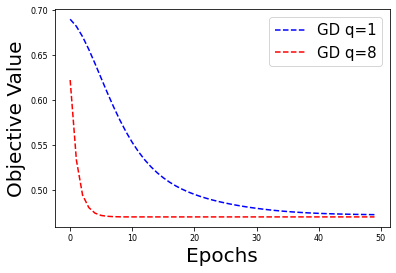

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd_1 = range(len(objective_val_1))
epochs_gd_8 = range(len(objective_val_8))

#epochs_gd_1 = range(int(communication1/2))
#epochs_gd_8 = range(int(communication1/2))


line0, = plt.plot(epochs_gd_1, objective_val_1, '--b', LineWidth=1.5)
line1, = plt.plot(epochs_gd_8, objective_val_8, '--r', LineWidth=1.5)

plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=8)
plt.yticks(FontSize=8)
plt.legend([line0, line1], ['GD q=1','GD q=8'], fontsize=15)
plt.show()

## Initialization for q=1 for SGD

In [ ]:
import math

#Create a server and m worker nodes
def create_server_workers(m, x, y, q, alpha, lam, beta):
    n, d = x.shape
    s = math.floor(n / m)
    server = Server(m, n, d, alpha, lam)
    workers = []
    
    for i in range(m):
        indices = list(range(i*s, (i+1)*s))
        #print(x.shape)
        worker = Worker(x[indices, :], y[indices, :], q, alpha, lam, beta)
        workers.append(worker)
        
    return server, workers

m = 4 #number of worker nodes
q = 1
lam = 1E-4 #regularization parameter
alpha = 0.01 #learning rate
beta = 0.9 #momentum parameter 
server, workers = create_server_workers(m, x_train, y_train, q, alpha, lam, beta)

In [ ]:
max_epoch = 50 #number of epochs
sgd_objective_val_1 = []
for t in range(max_epoch):
    print("----------------------------------epoch"+str(t)+"-------------------------------")
    #step 1: broadcast
    w = server.broadcast()
    for i in range(m):
        workers[i].set_param(w)
        
    #step 2: workers' local computations
    sgd_pk_1 = []
    sgd_losses_1 = []
    for i in range(m):
        print("Worker "+str(i+1))
        g = workers[i].find_stochdirection()
        sgd_pk_1.append(g)
        l = workers[i].loss()
        sgd_losses_1.append(l)
        
    #step 3: aggregate the workers' outputs
    server.aggregate(sgd_pk_1, sgd_losses_1)
    
    #step 4: server update the model parameters
    server.update() #compute gradient
    obj = server.objective() #compute objective function
    sgd_objective_val_1.append(obj)
    print('Objective function value = '+str(obj))
    

----------------------------------epoch0-------------------------------
Worker 1
local objective function value  0.6287224884659064
Worker 2
local objective function value  0.5285496692517379
Worker 3
local objective function value  0.5333475782255048
Worker 4
local objective function value  0.5281768626592486
Objective function value = 0.5236331637463572
----------------------------------epoch1-------------------------------
Worker 1
local objective function value  0.5015693370153547
Worker 2
local objective function value  0.46195882924352255
Worker 3
local objective function value  0.4981688829842555
Worker 4
local objective function value  0.5142383039982477
Objective function value = 0.48206101521619676
----------------------------------epoch2-------------------------------
Worker 1
local objective function value  0.48423497334570015
Worker 2
local objective function value  0.4499913296459317
Worker 3
local objective function value  0.4883137215944549
Worker 4
local objective func

## Initialization for q=8 for SGD

In [ ]:
import math

#Create a server and m worker nodes
def create_server_workers(m, x, y, q, alpha, lam, beta):
    n, d = x.shape
    s = math.floor(n / m)
    server = Server(m, n, d, alpha, lam)
    workers = []
    
    for i in range(m):
        indices = list(range(i*s, (i+1)*s))
        #print(x.shape)
        worker = Worker(x[indices, :], y[indices, :], q, alpha, lam, beta)
        workers.append(worker)
        
    return server, workers

m = 4 #number of worker nodes
q = 8
lam = 1E-4 #regularization parameter
alpha = 0.01 #learning rate
beta = 0.9 #momentum parameter 
server, workers = create_server_workers(m, x_train, y_train, q, alpha, lam, beta)

In [ ]:
max_epoch = 50 #number of epochs
sgd_objective_val_8 = []
for t in range(max_epoch):
    print("----------------------------------epoch"+str(t)+"-------------------------------")
    #step 1: broadcast
    w = server.broadcast()
    for i in range(m):
        workers[i].set_param(w)
        
    #step 2: workers' local computations
    sgd_pk_8 = []
    sgd_losses_8 = []
    for i in range(m):
        print("Worker "+str(i+1))
        g = workers[i].find_stochdirection()
        sgd_pk_8.append(g)
        l = workers[i].loss()
        sgd_losses_8.append(l)
        
    #step 3: aggregate the workers' outputs
    server.aggregate(sgd_pk_8, sgd_losses_8)
    
    #step 4: server update the model parameters
    server.update() #compute gradient
    obj = server.objective() #compute objective function
    sgd_objective_val_8.append(obj)
    print('Objective function value = '+str(obj))

----------------------------------epoch0-------------------------------
Worker 1
local objective function value  0.6298917027736011
local objective function value  0.5576837505879118
local objective function value  0.5266250403326801
local objective function value  0.5093537177694404
local objective function value  0.4987168899042489
local objective function value  0.49177076020448807
local objective function value  0.48686625740100686
local objective function value  0.48301031125165955
Worker 2
local objective function value  0.46186399020064933
local objective function value  0.4482874083259807
local objective function value  0.4408492074323173
local objective function value  0.4365870912732115
local objective function value  0.43360402666265435
local objective function value  0.43135001725293
local objective function value  0.4296144786334861
local objective function value  0.4283154006978222
Worker 3
local objective function value  0.5101538616418647
local objective function value 

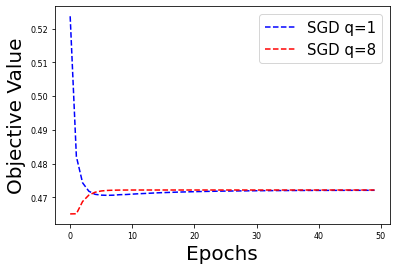

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_sgd_1 = range(len(sgd_objective_val_1))
epochs_sgd_8 = range(len(sgd_objective_val_8))


line0, = plt.plot(epochs_sgd_1, sgd_objective_val_1, '--b', LineWidth=1.5)
line1, = plt.plot(epochs_sgd_8, sgd_objective_val_8, '--r', LineWidth=1.5)

plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=8)
plt.yticks(FontSize=8)
plt.legend([line0, line1], ['SGD q=1','SGD q=8'], fontsize=15)
plt.show()

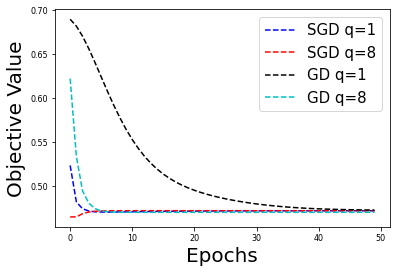

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_sgd_1 = range(len(sgd_objective_val_1))
epochs_sgd_8 = range(len(sgd_objective_val_8))


line0, = plt.plot(epochs_sgd_1, sgd_objective_val_1, '--b', LineWidth=1.5)
line1, = plt.plot(epochs_sgd_8, sgd_objective_val_8, '--r', LineWidth=1.5)
line2, = plt.plot(epochs_gd_1, objective_val_1, '--k', LineWidth=1.5)
line3, = plt.plot(epochs_gd_8, objective_val_8, '--c', LineWidth=1.5)

plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=8)
plt.yticks(FontSize=8)
plt.legend([line0, line1, line2, line3], ['SGD q=1','SGD q=8', 'GD q=1', 'GD q=8'], fontsize=15)
plt.show()